# Title

```markdown
TITLE   :  
AUTHOR  :
PROJECT :  
```


<span style='font-size:30px;font-weight:650'>
    About
</span>


Saving animations in Matplotlib can be difficult because Matplotlib needs to interface with operating system tools that may or may not exist on you r computer and may or may not be installed correctly.
I am using a Mac (OS Catalina) with Python 3.7.3 and have only managed to get a working copy of `ffmpeg`, an MP4 encoder, using Homebrew. Conda and pip did not work.

```
Python 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)] :: Anaconda, Inc. on darwin
```


<br><br>

- - - 
- - - 

<br>

# Prepare

## Imports

In [ ]:
# from astroPHD import ipython
# ipython.run_imports(base=True, astropy=True, matplotlib=True)

# ## General

# ## Custom

# ## Project-Specific

<br><br>

- - - 
- - - 

<br>

# Code

In [2]:
"""
Animation of Elastic collisions with Gravity

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""
import numpy as np
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

class ParticleBox:
    """Orbits class
    
    init_state is an [N x 4] array, where N is the number of particles:
       [[x1, y1, vx1, vy1],
        [x2, y2, vx2, vy2],
        ...               ]

    bounds is the size of the box: [xmin, xmax, ymin, ymax]
    """
    def __init__(self,
                 init_state = [[1, 0, 0, -1],
                               [-0.5, 0.5, 0.5, 0.5],
                               [-0.5, -0.5, -0.5, 0.5]],
                 bounds = [-2, 2, -2, 2],
                 size = 0.04,
                 M = 0.05,
                 G = 9.8):
        self.init_state = np.asarray(init_state, dtype=float)
        self.M = M * np.ones(self.init_state.shape[0])
        self.size = size
        self.state = self.init_state.copy()
        self.time_elapsed = 0
        self.bounds = bounds
        self.G = G

    def step(self, dt):
        """step once by dt seconds"""
        self.time_elapsed += dt
        
        # update positions
        self.state[:, :2] += dt * self.state[:, 2:]

        # find pairs of particles undergoing a collision
        D = squareform(pdist(self.state[:, :2]))
        ind1, ind2 = np.where(D < 2 * self.size)
        unique = (ind1 < ind2)
        ind1 = ind1[unique]
        ind2 = ind2[unique]

        # update velocities of colliding pairs
        for i1, i2 in zip(ind1, ind2):
            # mass
            m1 = self.M[i1]
            m2 = self.M[i2]

            # location vector
            r1 = self.state[i1, :2]
            r2 = self.state[i2, :2]

            # velocity vector
            v1 = self.state[i1, 2:]
            v2 = self.state[i2, 2:]

            # relative location & velocity vectors
            r_rel = r1 - r2
            v_rel = v1 - v2

            # momentum vector of the center of mass
            v_cm = (m1 * v1 + m2 * v2) / (m1 + m2)

            # collisions of spheres reflect v_rel over r_rel
            rr_rel = np.dot(r_rel, r_rel)
            vr_rel = np.dot(v_rel, r_rel)
            v_rel = 2 * r_rel * vr_rel / rr_rel - v_rel

            # assign new velocities
            self.state[i1, 2:] = v_cm + v_rel * m2 / (m1 + m2)
            self.state[i2, 2:] = v_cm - v_rel * m1 / (m1 + m2) 

        # check for crossing boundary
        crossed_x1 = (self.state[:, 0] < self.bounds[0] + self.size)
        crossed_x2 = (self.state[:, 0] > self.bounds[1] - self.size)
        crossed_y1 = (self.state[:, 1] < self.bounds[2] + self.size)
        crossed_y2 = (self.state[:, 1] > self.bounds[3] - self.size)

        self.state[crossed_x1, 0] = self.bounds[0] + self.size
        self.state[crossed_x2, 0] = self.bounds[1] - self.size

        self.state[crossed_y1, 1] = self.bounds[2] + self.size
        self.state[crossed_y2, 1] = self.bounds[3] - self.size

        self.state[crossed_x1 | crossed_x2, 2] *= -1
        self.state[crossed_y1 | crossed_y2, 3] *= -1

        # add gravity
        self.state[:, 3] -= self.M * self.G * dt


#------------------------------------------------------------
# set up initial state
np.random.seed(0)
init_state = -0.5 + np.random.random((50, 4))
init_state[:, :2] *= 3.9

box = ParticleBox(init_state, size=0.04)
dt = 1. / 30 # 30fps


#------------------------------------------------------------
# set up figure and animation
fig = plt.figure()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-3.2, 3.2), ylim=(-2.4, 2.4))

# particles holds the locations of the particles
particles, = ax.plot([], [], 'bo', ms=6)

# rect is the box edge
rect = plt.Rectangle(box.bounds[::2],
                     box.bounds[1] - box.bounds[0],
                     box.bounds[3] - box.bounds[2],
                     ec='none', lw=2, fc='none')
ax.add_patch(rect)

def init():
    """initialize animation"""
    global box, rect
    particles.set_data([], [])
    rect.set_edgecolor('none')
    return particles, rect

def animate(i):
    """perform animation step"""
    global box, rect, dt, ax, fig
    box.step(dt)

    ms = int(fig.dpi * 2 * box.size * fig.get_figwidth()
             / np.diff(ax.get_xbound())[0])
    
    # update pieces of the animation
    rect.set_edgecolor('k')
    particles.set_data(box.state[:, 0], box.state[:, 1])
    particles.set_markersize(ms)
    return particles, rect

ani = animation.FuncAnimation(fig, animate, frames=600,
                              interval=10, blit=True, init_func=init)


# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
# ani.save('particle_box.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
ani.save('particle_box.html', fps=30, extra_args=['-vcodec', 'libx264'])

plt.show()



MovieWriter stderr:
Unknown encoder 'libx264'



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-vcodec', 'libx264', '-y', 'particle_box.mp4']' returned non-zero exit status 1.

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.HTMLWriter'> instead.


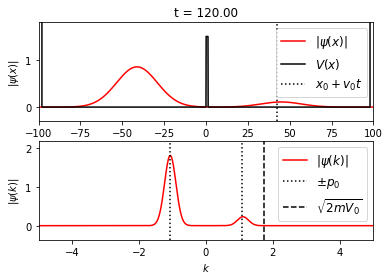

In [4]:
"""
General Numerical Solver for the 1D Time-Dependent Schrodinger's equation.

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as pl
from matplotlib import animation
from scipy.fftpack import fft,ifft


class Schrodinger(object):
    """
    Class which implements a numerical solution of the time-dependent
    Schrodinger equation for an arbitrary potential
    """
    def __init__(self, x, psi_x0, V_x,
                 k0 = None, hbar=1, m=1, t0=0.0):
        """
        Parameters
        ----------
        x : array_like, float
            length-N array of evenly spaced spatial coordinates
        psi_x0 : array_like, complex
            length-N array of the initial wave function at time t0
        V_x : array_like, float
             length-N array giving the potential at each x
        k0 : float
            the minimum value of k.  Note that, because of the workings of the
            fast fourier transform, the momentum wave-number will be defined
            in the range
              k0 < k < 2*pi / dx
            where dx = x[1]-x[0].  If you expect nonzero momentum outside this
            range, you must modify the inputs accordingly.  If not specified,
            k0 will be calculated such that the range is [-k0,k0]
        hbar : float
            value of planck's constant (default = 1)
        m : float
            particle mass (default = 1)
        t0 : float
            initial tile (default = 0)
        """
        # Validation of array inputs
        self.x, psi_x0, self.V_x = map(np.asarray, (x, psi_x0, V_x))
        N = self.x.size
        assert self.x.shape == (N,)
        assert psi_x0.shape == (N,)
        assert self.V_x.shape == (N,)

        # Set internal parameters
        self.hbar = hbar
        self.m = m
        self.t = t0
        self.dt_ = None
        self.N = len(x)
        self.dx = self.x[1] - self.x[0]
        self.dk = 2 * np.pi / (self.N * self.dx)

        # set momentum scale
        if k0 == None:
            self.k0 = -0.5 * self.N * self.dk
        else:
            self.k0 = k0
        self.k = self.k0 + self.dk * np.arange(self.N)

        self.psi_x = psi_x0
        self.compute_k_from_x()

        # variables which hold steps in evolution of the
        self.x_evolve_half = None
        self.x_evolve = None
        self.k_evolve = None

        # attributes used for dynamic plotting
        self.psi_x_line = None
        self.psi_k_line = None
        self.V_x_line = None

    def _set_psi_x(self, psi_x):
        self.psi_mod_x = (psi_x * np.exp(-1j * self.k[0] * self.x)
                          * self.dx / np.sqrt(2 * np.pi))

    def _get_psi_x(self):
        return (self.psi_mod_x * np.exp(1j * self.k[0] * self.x)
                * np.sqrt(2 * np.pi) / self.dx)

    def _set_psi_k(self, psi_k):
        self.psi_mod_k = psi_k * np.exp(1j * self.x[0]
                                        * self.dk * np.arange(self.N))

    def _get_psi_k(self):
        return self.psi_mod_k * np.exp(-1j * self.x[0] * 
                                        self.dk * np.arange(self.N))
    
    def _get_dt(self):
        return self.dt_

    def _set_dt(self, dt):
        if dt != self.dt_:
            self.dt_ = dt
            self.x_evolve_half = np.exp(-0.5 * 1j * self.V_x
                                         / self.hbar * dt )
            self.x_evolve = self.x_evolve_half * self.x_evolve_half
            self.k_evolve = np.exp(-0.5 * 1j * self.hbar /
                                    self.m * (self.k * self.k) * dt)
    
    psi_x = property(_get_psi_x, _set_psi_x)
    psi_k = property(_get_psi_k, _set_psi_k)
    dt = property(_get_dt, _set_dt)

    def compute_k_from_x(self):
        self.psi_mod_k = fft(self.psi_mod_x)

    def compute_x_from_k(self):
        self.psi_mod_x = ifft(self.psi_mod_k)

    def time_step(self, dt, Nsteps = 1):
        """
        Perform a series of time-steps via the time-dependent
        Schrodinger Equation.

        Parameters
        ----------
        dt : float
            the small time interval over which to integrate
        Nsteps : float, optional
            the number of intervals to compute.  The total change
            in time at the end of this method will be dt * Nsteps.
            default is N = 1
        """
        self.dt = dt

        if Nsteps > 0:
            self.psi_mod_x *= self.x_evolve_half

        for i in range(Nsteps - 1):
            self.compute_k_from_x()
            self.psi_mod_k *= self.k_evolve
            self.compute_x_from_k()
            self.psi_mod_x *= self.x_evolve

        self.compute_k_from_x()
        self.psi_mod_k *= self.k_evolve

        self.compute_x_from_k()
        self.psi_mod_x *= self.x_evolve_half

        self.compute_k_from_x()

        self.t += dt * Nsteps


######################################################################
# Helper functions for gaussian wave-packets

def gauss_x(x, a, x0, k0):
    """
    a gaussian wave packet of width a, centered at x0, with momentum k0
    """ 
    return ((a * np.sqrt(np.pi)) ** (-0.5)
            * np.exp(-0.5 * ((x - x0) * 1. / a) ** 2 + 1j * x * k0))

def gauss_k(k,a,x0,k0):
    """
    analytical fourier transform of gauss_x(x), above
    """
    return ((a / np.sqrt(np.pi))**0.5
            * np.exp(-0.5 * (a * (k - k0)) ** 2 - 1j * (k - k0) * x0))


######################################################################
# Utility functions for running the animation

def theta(x):
    """
    theta function :
      returns 0 if x<=0, and 1 if x>0
    """
    x = np.asarray(x)
    y = np.zeros(x.shape)
    y[x > 0] = 1.0
    return y

def square_barrier(x, width, height):
    return height * (theta(x) - theta(x - width))

######################################################################
# Create the animation

# specify time steps and duration
dt = 0.01
N_steps = 50
t_max = 120
frames = int(t_max / float(N_steps * dt))

# specify constants
hbar = 1.0   # planck's constant
m = 1.9      # particle mass

# specify range in x coordinate
N = 2 ** 11
dx = 0.1
x = dx * (np.arange(N) - 0.5 * N)

# specify potential
V0 = 1.5
L = hbar / np.sqrt(2 * m * V0)
a = 3 * L
x0 = -60 * L
V_x = square_barrier(x, a, V0)
V_x[x < -98] = 1E6
V_x[x > 98] = 1E6

# specify initial momentum and quantities derived from it
p0 = np.sqrt(2 * m * 0.2 * V0)
dp2 = p0 * p0 * 1./80
d = hbar / np.sqrt(2 * dp2)

k0 = p0 / hbar
v0 = p0 / m
psi_x0 = gauss_x(x, d, x0, k0)

# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,
                psi_x0=psi_x0,
                V_x=V_x,
                hbar=hbar,
                m=m,
                k0=-28)

######################################################################
# Set up plot
fig = pl.figure()

# plotting limits
xlim = (-100, 100)
klim = (-5, 5)

# top axes show the x-space data
ymin = 0
ymax = V0
ax1 = fig.add_subplot(211, xlim=xlim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_x_line, = ax1.plot([], [], c='r', label=r'$|\psi(x)|$')
V_x_line, = ax1.plot([], [], c='k', label=r'$V(x)$')
center_line = ax1.axvline(0, c='k', ls=':',
                          label = r"$x_0 + v_0t$")

title = ax1.set_title("")
ax1.legend(prop=dict(size=12))
ax1.set_xlabel('$x$')
ax1.set_ylabel(r'$|\psi(x)|$')

# bottom axes show the k-space data
ymin = abs(S.psi_k).min()
ymax = abs(S.psi_k).max()
ax2 = fig.add_subplot(212, xlim=klim,
                      ylim=(ymin - 0.2 * (ymax - ymin),
                            ymax + 0.2 * (ymax - ymin)))
psi_k_line, = ax2.plot([], [], c='r', label=r'$|\psi(k)|$')

p0_line1 = ax2.axvline(-p0 / hbar, c='k', ls=':', label=r'$\pm p_0$')
p0_line2 = ax2.axvline(p0 / hbar, c='k', ls=':')
mV_line = ax2.axvline(np.sqrt(2 * V0) / hbar, c='k', ls='--',
                      label=r'$\sqrt{2mV_0}$')
ax2.legend(prop=dict(size=12))
ax2.set_xlabel('$k$')
ax2.set_ylabel(r'$|\psi(k)|$')

V_x_line.set_data(S.x, S.V_x)

######################################################################
# Animate plot
def init():
    psi_x_line.set_data([], [])
    V_x_line.set_data([], [])
    center_line.set_data([], [])

    psi_k_line.set_data([], [])
    title.set_text("")
    return (psi_x_line, V_x_line, center_line, psi_k_line, title)

def animate(i):
    S.time_step(dt, N_steps)
    psi_x_line.set_data(S.x, 4 * abs(S.psi_x))
    V_x_line.set_data(S.x, S.V_x)
    center_line.set_data(2 * [x0 + S.t * p0 / m], [0, 1])

    psi_k_line.set_data(S.k, abs(S.psi_k))
    title.set_text("t = %.2f" % S.t)
    return (psi_x_line, V_x_line, center_line, psi_k_line, title)

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=30, blit=True)


# uncomment the following line to save the video in mp4 format.  This
# requires either mencoder or ffmpeg to be installed on your system

# anim.save('schrodinger_barrier.mp4', fps=15, extra_args=['-vcodec', 'libx264'])
anim.save('schrodinger_barrier.html', fps=15, extra_args=['-vcodec', 'libx264'])

pl.show()



In [1]:
from numpy import sin, cos
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

G = 9.8  # acceleration due to gravity, in m/s^2
L1 = 1.0  # length of pendulum 1 in m
L2 = 1.0  # length of pendulum 2 in m
M1 = 1.0  # mass of pendulum 1 in kg
M2 = 1.0  # mass of pendulum 2 in kg


def derivs(state, t):

    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (M1+M2) * L1 - M2 * L1 * cos(delta) * cos(delta)
    dydx[1] = ((M2 * L1 * state[1] * state[1] * sin(delta) * cos(delta)
                + M2 * G * sin(state[2]) * cos(delta)
                + M2 * L2 * state[3] * state[3] * sin(delta)
                - (M1+M2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (L2/L1) * den1
    dydx[3] = ((- M2 * L2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (M1+M2) * G * sin(state[0]) * cos(delta)
                - (M1+M2) * L1 * state[1] * state[1] * sin(delta)
                - (M1+M2) * G * sin(state[2]))
               / den2)

    return dydx

# create a time array from 0..100 sampled at 0.05 second steps
dt = 0.05
t = np.arange(0, 20, dt)

# th1 and th2 are the initial angles (degrees)
# w10 and w20 are the initial angular velocities (degrees per second)
th1 = 120.0
w1 = 0.0
th2 = -10.0
w2 = 0.0

# initial state
state = np.radians([th1, w1, th2, w2])

# integrate your ODE using scipy.integrate.
y = integrate.odeint(derivs, state, t)

x1 = L1*sin(y[:, 0])
y1 = -L1*cos(y[:, 0])

x2 = L2*sin(y[:, 2]) + x1
y2 = -L2*cos(y[:, 2]) + y1

fig = plt.figure()
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2, 2), ylim=(-2, 2))
ax.set_aspect('equal')
ax.grid()

line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)


def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text


def animate(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*dt))
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(1, len(y)),
                              interval=dt*1000, blit=True, init_func=init)
ani.save('test.mp4')
plt.show()

MovieWriter mencoder unavailable; trying to use <class 'matplotlib.animation.FFMpegWriter'> instead.


<Figure size 640x480 with 1 Axes>

<br><br>

- - - 
- - - 

<span style='font-size:40px;font-weight:650'>
    END
</span>